# Table of contents
- [Setup](#setup)
    - [Purpose](#purpose)
    - [Libraries](#libraries)
- [Forty random research papers](#fortyrandomresearchpapers)
- [Quality assurance](#qualityassurance)
    - [Labeled data](#labeleddata)
    - [Inter-annotator agreement](#interannotatoragreement)
- [Investigation](#investigation)
    - [Majority vote](#majorityvote)
        - [Save the labeled data for fine-tuning](#savethelabeleddataforfine-tuning) 
    - [Visualization](#visualization)
        - [Labels used by each labeler](#labelsusedbyeachlabeler)
        - [Labels occurring together](#labelsoccurringtogether)
- [References](#references)

<a name='setup'></a>
# 0. Setup

<a name='purpose'></a>
## 0.1. Purpose

The following steps are performed:

- Randomly select 40 articles to be manually labelled
- Gather the extracted URLs and sentences (this is done in 'Code/datasets_v5.ipynb')
- The sentences are manually coded by three people
- Gather the manually coded data
    - Investigate inter-labeller agreement
    - Save most-agreed-upon label for each sentence
- Fine-tune SciBERT (this is done in 'Code/datasets_v5.ipynb')


<a name='libraries'></a>
## 0.2. Libraries

In [1]:
import pandas as pd
import numpy as np
import os 
import re 
import io
import json
import csv 

# Random 
import random

# Read docx files 
import docx2txt

# NLTK 
from nltk.metrics import agreement, masi_distance, jaccard_distance
from nltk.metrics.agreement import AnnotationTask 

# For visualizations 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

<a name='fortyrandomresearchpapers'></a>
# 1. Forty random research papers 

I need to get the list of groundtruth research papers to make sure I do not select them for manual labeling.
Then I will manually label the sentences containing URLs from 40 randomly selected research papers. 

First, I need to get the research papers.

In [2]:
groundtruth_path = os.path.join(os.pardir, '../Data/articles_groundtruth_urls_and_sentences.csv')
groundtruth_articles = pd.read_csv(groundtruth_path)

In [3]:
groundtruth_dois = groundtruth_articles['DOI'].unique()

I want to manually label the sentences containing URLs from 40 randomly selected research papers. First, I need to get the research papers. 

In [4]:
def get_random_dois(json_file_path, num_samples, dois_to_exclude=None, random_seed=42):
    """
    Get a list of random DOIs from a JSON file while ensuring that they are not in the groundtruth DOI list.

    Parameters:
    json_file_path (str): The path to the JSON file containing DOI data.
    num_samples (int): The number of random DOIs to sample.
    dois_to_exclude (list, optional): A list of DOIs to exclude from the random sampling. Default is None.
    random_seed (int, optional): Seed for the random number generator for reproducibility. Default is 42.

    Returns:
    list: A list of unique random DOIs not in the groundtruth DOI list.
    """
    # Set the random seed for reproducibility
    random.seed(random_seed)

    # Load the DOI data from the JSON file
    with open(json_file_path, 'r') as json_file:
        doi_data = json.load(json_file)
        doi_list = doi_data['DOIs']

    doi_list = [doi for doi in doi_list if doi not in groundtruth_dois]

    # Ensure the number of requested samples does not exceed available DOIs
    num_samples = min(num_samples, len(doi_list))

    # Get a sample of DOIs
    random_dois = random.sample(doi_list, num_samples)

    return random_dois

In [5]:
# Path to the JSON file containing DOI values
json_file_path = '../../Data/ElsevierAPI/downloadedPDFs_info.json'
samples = 40

# Get 40 random DOIs with a specific random seed (1)
random_dois = get_random_dois(json_file_path, samples, groundtruth_dois)

random_dois

['10.1016/j.neuroimage.2022.119290',
 '10.1016/j.neuroimage.2022.118980',
 '10.1016/j.neuroimage.2022.119191',
 '10.1016/j.neuroimage.2022.119140',
 '10.1016/j.neuroimage.2022.119203',
 '10.1016/j.neuroimage.2022.119494',
 '10.1016/j.neuroimage.2022.119708',
 '10.1016/j.neuroimage.2022.119245',
 '10.1016/j.neuroimage.2022.119418',
 '10.1016/j.neuroimage.2022.119616',
 '10.1016/j.neuroimage.2022.118920',
 '10.1016/j.neuroimage.2022.119122',
 '10.1016/j.neuroimage.2021.118811',
 '10.1016/j.neuroimage.2022.119353',
 '10.1016/j.neuroimage.2022.119094',
 '10.1016/j.neuroimage.2022.119626',
 '10.1016/j.neuroimage.2022.119742',
 '10.1016/j.neuroimage.2022.119135',
 '10.1016/j.neuroimage.2022.119331',
 '10.1016/j.neuroimage.2022.119278',
 '10.1016/j.neuroimage.2021.118798',
 '10.1016/j.neuroimage.2022.119055',
 '10.1016/j.neuroimage.2022.119507',
 '10.1016/j.neuroimage.2022.119642',
 '10.1016/j.neuroimage.2022.119627',
 '10.1016/j.neuroimage.2022.119668',
 '10.1016/j.neuroimage.2022.119528',
 

In [6]:
path = os.path.join(os.pardir, '../Data/QA_manually_labeled_data/DOI_forty.csv')

# Write the list of numbers to the CSV file
with open(path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    csv_writer.writerow(['DOI'])   
    
    for doi in random_dois:
        csv_writer.writerow([doi])

Now, I will save all of the extracted URLs and sentences (which is performed in Code/datasets_v5) to csv, so that the sentences can be labelled manually by a group of annotators. 

In [7]:
path_filtered_urls = os.path.join(os.pardir, '../Data/articles_filtered_urls.csv')
filtered_urls = pd.read_csv(path_filtered_urls)

In [8]:
filtered_urls = filtered_urls[filtered_urls['URL'].notna()]

In [9]:
random_articles = filtered_urls[filtered_urls['DOI'].isin(random_dois)]
random_articles = random_articles.sort_values(by=['URL'])

In [10]:
len(random_articles)

129

In [11]:
path = os.path.join(os.pardir, '../Data/QA_manually_labeled_data/articles_sentences_to_be_labelled.txt')

with open(path, "w") as file:
    file.write(random_articles.to_string(index=False))

In [12]:
# Remove square brackets and quotes from the 'Sentences' column
random_articles['Sentences'] = random_articles['Sentences'].str.replace(r"['\[\]']", '', regex=True)

In [13]:
random_articles = random_articles.reset_index(drop=True)

In [14]:
original_sentences = random_articles['Sentences']

<a name='qualityassurance'></a>
# 2. Quality assurance 

Four annotators will manually label the data in 'Data/QA_manually_labeled_data/articles_sentences_to_be_labelled.txt'. The labeling guide is located in 'Resources/LabelingGuide.pdf'. They will use the platform Taguette (Rampin & Rampin 2021) to label the data. The data will be used to fine-tune the Sci-BERT model in 'Code/datasets_v5.ipynb'. 


Inter-annotator agreement indices: 
- All can work with nominal data - Krippendorf's Alpha can handle missing data.
- Fleiss' Kappa and Krippendorf's Alpha work with two or more raters.

<a name='labeleddata'></a>
## 2.1. Labeled data 

In [15]:
def get_sentences(text, label_mapping, original_sentences, short):
    """This function extracts all occurrences of [''] and everything within them.
    """
    #pattern = r'\[‘(.*?)\] | \[‘(.*?‘*?)\] | \[‘(.*?‘*?\)*?)\] '    
    pattern = r'\[‘(.*‘*\)*)\]'
    
    sentences = re.findall(pattern, text)
    all_sentences = []  # A list to store all sentences
    all_labels = []  # A list to store all labels

    for sentence in sentences:
        label = get_labels(sentence, label_mapping)
        all_sentences.append(sentence)
        all_labels.append(label)
        
    df = pd.DataFrame({'Original_sentence': original_sentences, 'Sentence': all_sentences, 'Labels': all_labels, 'Sentence_ID': short})
    
    return df

def get_labels(sentence, label_mapping):
    """This function extracts all occurrences of [] and everything within them,
    and maps labels to their corresponding integer values using label_mapping.
    """
    labels = []
    pattern = r'\[+[^\s-].*'
    label_matches = re.findall(pattern, sentence)

    for label_match in label_matches:
        label_match = label_match.strip().replace('[', '').replace(']', '').replace('(', '').replace(')', '').replace('“', '').replace('”', '').replace("’", '').strip('.').strip('/') 
        label_list = [label.strip() for label in label_match.split(',')]
        label_ids = []
        for label in label_list:
            for key, value in label_mapping.items():
                if label in key:
                    if value not in label_ids:  # Check if value is already in the list
                        label_ids.append(value)
        #labels.append(label_ids)
        labels.extend(label_ids)
    
    return labels


def get_data_from_docx(docx_paths, label_mapping, original_sentences, short):
    """
    """
    df = pd.DataFrame(columns=['Annotator', 'Sentence', 'Labels'])

    for annotator, docx_path in docx_paths.items():
        try:
            docx_text = docx2txt.process(docx_path)
            annotator_name = os.path.basename(docx_path).replace('.docx', '')
            
            sentences_df = get_sentences(docx_text, label_mapping, original_sentences, short)
            sentences_df['Annotator'] = annotator_name

            df = pd.concat([df, sentences_df], ignore_index=True)

        except Exception as e:
            print(f"Error reading DOCX: {e}")

    return df

In [16]:
# Paths to the PDF files
data_path = os.path.join(os.pardir, '../Data/QA_manually_labeled_data')
text_paths = {
    'a1': os.path.join(data_path, 'AnonymousAxolotl.docx'),
    'a2': os.path.join(data_path, 'AnonymousPlatypus.docx'),
    'a3': os.path.join(data_path, 'AnonymousQuokka.docx')
}

label_mapping = {
    "Analysis": 'ana',
    "Atlas/map": 'at_map',
    "Dataset": 'data',
    "Model": 'mod',
    "Not a URL": 'no_url',
    "Not enough information": 'no_info',
    "Person or institution": 'pers_inst',
    "Processed dataset": 'pro_data',
    "Resource": 'res',
    "Software, incl. plugins, toolbox, packages, and functions": 'soft'
}

original_sentences = random_articles['Sentences']
short = []
i = 0
for sentence in original_sentences:
    i = int(i)
    i = i+1
    i = str(i)
    result = "sentence"+i
    short.append(result)

sentences_df = get_data_from_docx(text_paths, label_mapping, original_sentences, short)

In [17]:
sentences_df[sentences_df['Labels'].isna()]

,Annotator,Sentence,Labels,Original_sentence,Sentence_ID


In [18]:
sentences_df

,Annotator,Sentence,Labels,Original_sentence,Sentence_ID
0,AnonymousAxolotl,"In addition, as introduced in Section 3.1.3.1 ...",[no_url],"In addition, as introduced in Section 3.1.3.1 ...",sentence1
1,AnonymousAxolotl,"Vries, I.E.J.de, Driel, J.van, Olivers, C.N.L....",[no_url],"Vries, I.E.J.de, Driel, J.van, Olivers, C.N.L....",sentence2
2,AnonymousAxolotl,All electrode coordinates and labels were save...,[data],All electrode coordinates and labels were save...,sentence3
3,AnonymousAxolotl,"Wen, J., Thibeau-Sutre, E., Diaz-Melo, M., Sam...",[no_url],"Wen, J., Thibeau-Sutre, E., Diaz-Melo, M., Sam...",sentence4
4,AnonymousAxolotl,∗ Data used in preparation of this article wer...,[data],∗ Data used in preparation of this article wer...,sentence5
...,...,...,...,...,...
382,AnonymousQuokka,Funding JD was funded by the Rennes Clinical N...,[pers_inst],Funding JD was funded by the Rennes Clinical N...,sentence125
383,AnonymousQuokka,We used MRIcroGL (www.mccauslandcenter.sc.edu/...,[soft],We used MRIcroGL (www.mccauslandcenter.sc.edu/...,sentence126
384,AnonymousQuokka,The 3D figure was realized using BrainNet view...,[soft],The 3D ﬁgure was realized using BrainNet viewe...,sentence127
385,AnonymousQuokka,Seed-based d mapping The SDM-PSI (www.sdmproje...,[soft],Seed-based d mapping The SDM-PSI (www.sdmproje...,sentence128


In [19]:
sentences_df[sentences_df['Labels'].apply(lambda x: len(x) > 1)]

,Annotator,Sentence,Labels,Original_sentence,Sentence_ID
41,AnonymousAxolotl,(2021) https://appsrv.cse.cuhk.edu.hk/∼qdou/cm...,"[data, soft]",(2021) https://appsrv.cse.cuhk.edu.hk/∼qdou/cm...,sentence42
71,AnonymousAxolotl,NeuroImage 260 (2022) 119494 Data and code ava...,"[soft, at_map]",NeuroImage 260 (2022) 119494 Data and code ava...,sentence72
72,AnonymousAxolotl,Code availability All the Matlab and R codes u...,"[soft, ana, at_map]",Code availability All the Matlab and R codes u...,sentence73
80,AnonymousAxolotl,Code availability Code for the model and analy...,"[soft, ana]",Code availability Code for the model and analy...,sentence81
88,AnonymousAxolotl,Data and code availability statement The data ...,"[ana, data]",Data and code availability statement The data ...,sentence89
91,AnonymousAxolotl,Data and code availability The data used in th...,"[ana, data]",Data and code availability The data used in th...,sentence92
92,AnonymousAxolotl,Data availability statement Data and code are ...,"[soft, data]",Data availability statement Data and code are ...,sentence93
96,AnonymousAxolotl,Data Availability Data and code supporting the...,"[data, ana]",Data Availability Data and code supporting the...,sentence97
119,AnonymousAxolotl,Data Availability Data and code supporting the...,"[ana, data]",Data Availability Data and code supporting the...,sentence120
133,AnonymousPlatypus,∗ Data used in preparation of this article wer...,"[res, data]",∗ Data used in preparation of this article wer...,sentence5


In [20]:
sentences_df.loc[0].values

array(['AnonymousAxolotl',
       'In addition, as introduced in Section 3.1.3.1 ‘Classical image processing’, RST outputs voxel-wise maps with intensities indicating local radial symmetry, and can therefore be used as shape features in clas-sical machine learning approaches (Roy et al., 2015). [Not a URL]’',
       list(['no_url']),
       'In addition, as introduced in Section 3.1.3.1 ‘Classical image pro-cessing’, RST outputs voxel-wise maps with intensities indicating local radial symmetry, and can therefore be used as shape features in clas-sical machine learning approaches (Roy et al., 2015).',
       'sentence1'], dtype=object)

In [21]:
sentences_df.loc[41].values

array(['AnonymousAxolotl',
       '(2021) https://appsrv.cse.cuhk.edu.hk/∼qdou/cmb-3dcnn/cmb-3dcnn.html code and labelled data for CMB segmentation Dou et al. [Dataset, Software, incl. plugins, toolbox, packages, and functions]’',
       list(['data', 'soft']),
       '(2021) https://appsrv.cse.cuhk.edu.hk/∼qdou/cmb-3dcnn/cmb-3dcnn.html code and labelled data for CMB segmentation Dou et al.',
       'sentence42'], dtype=object)

In [22]:
sentences_df

,Annotator,Sentence,Labels,Original_sentence,Sentence_ID
0,AnonymousAxolotl,"In addition, as introduced in Section 3.1.3.1 ...",[no_url],"In addition, as introduced in Section 3.1.3.1 ...",sentence1
1,AnonymousAxolotl,"Vries, I.E.J.de, Driel, J.van, Olivers, C.N.L....",[no_url],"Vries, I.E.J.de, Driel, J.van, Olivers, C.N.L....",sentence2
2,AnonymousAxolotl,All electrode coordinates and labels were save...,[data],All electrode coordinates and labels were save...,sentence3
3,AnonymousAxolotl,"Wen, J., Thibeau-Sutre, E., Diaz-Melo, M., Sam...",[no_url],"Wen, J., Thibeau-Sutre, E., Diaz-Melo, M., Sam...",sentence4
4,AnonymousAxolotl,∗ Data used in preparation of this article wer...,[data],∗ Data used in preparation of this article wer...,sentence5
...,...,...,...,...,...
382,AnonymousQuokka,Funding JD was funded by the Rennes Clinical N...,[pers_inst],Funding JD was funded by the Rennes Clinical N...,sentence125
383,AnonymousQuokka,We used MRIcroGL (www.mccauslandcenter.sc.edu/...,[soft],We used MRIcroGL (www.mccauslandcenter.sc.edu/...,sentence126
384,AnonymousQuokka,The 3D figure was realized using BrainNet view...,[soft],The 3D ﬁgure was realized using BrainNet viewe...,sentence127
385,AnonymousQuokka,Seed-based d mapping The SDM-PSI (www.sdmproje...,[soft],Seed-based d mapping The SDM-PSI (www.sdmproje...,sentence128


Are there any missing labels? 

In [23]:
missing_labels = sentences_df[sentences_df['Labels'].apply(lambda x: len(x) < 1)]

In [24]:
missing_labels

,Annotator,Sentence,Labels,Original_sentence,Sentence_ID
8,AnonymousAxolotl,More de-tails concerning the sMRI images is av...,[],More de-tails concerning the sMRI images is av...,sentence9
81,AnonymousAxolotl,(2016) https://github.com/hjkuijf/MixLacune co...,[],(2016) https://github.com/hjkuijf/MixLacune co...,sentence82
106,AnonymousAxolotl,Census data was obtained from the United State...,[],Census data was obtained from the United State...,sentence107


In [25]:
no_label = ['no_label']

sentences_df['Labels'] = sentences_df['Labels'].apply(lambda x: no_label if len(x) < 1 else x)

In [26]:
missing_labels = sentences_df[sentences_df['Labels'].apply(lambda x: len(x) < 1)]

In [27]:
missing_labels

,Annotator,Sentence,Labels,Original_sentence,Sentence_ID


In [28]:
unique_labels = sentences_df['Labels'].explode().unique()

In [29]:
unique_labels

array(['no_url', 'data', 'res', 'no_info', 'ana', 'no_label', 'soft',
       'pro_data', 'at_map', 'mod', 'pers_inst'], dtype=object)

<a name='interannotatoragreement'></a>
## 2.2. Inter-annotator agreement 

I will use NLTK's (Bird et al. 2009) agreement module (NLTK 2023) to investigate the inter-annotator agreement among the labelers who helped me. This module contains implementations of various inter-annotator agreement coefficients surveyed by Artstein and Poesio (2007). As stated in the module: "An agreement coefficient calculates the amount that annotators agreed on label assignments beyond what is expected by chance." (NLTK 2023). 

To use the module, I have to modify the data, as the simplest way to initialize an AnnotationTask is with a list of triples, each containing the coder's (c) label (v) assigned to an object (i): 

    data = [('c1', '1', 'v1'), ('c2', '1', 'v1'), ('c1', '2', 'v2'), ...]

In [30]:
sentences_df.loc[0]

Annotator                                             AnonymousAxolotl
Sentence             In addition, as introduced in Section 3.1.3.1 ...
Labels                                                        [no_url]
Original_sentence    In addition, as introduced in Section 3.1.3.1 ...
Sentence_ID                                                  sentence1
Name: 0, dtype: object

In [31]:
# The toy_data shows how things are supposed to look for the AnnotationTask
toy_data = [('anon1','sent1', ['Analysis','Processed dataset']),
            ('anon2','sent1', ['Analysis']),
            ('anon3','sent1', ['Analysis', 'Processed dataset', 'Dataset']),
            ('anon4','sent1', ['Processed dataset']),
            ('anon1','sent2', ['None']),
            ('anon2','sent2', ['Dataset', 'Processed dataset']),
            ('anon3','sent2', ['Dataset', 'Processed dataset']),
            ('anon4','sent2', ['Dataset']),
            ('anon1','sent3', ['Atlas/map']),
            ('anon2','sent3', ['Atlas/map']),
            ('anon3','sent3', ['Atlas/map']),
            ('anon4','sent3', ['Atlas/map']),
            ('anon1','sent4', ['None','Software, incl. plugins, toolbox, packages, and functions']),
            ('anon2','sent4', ['Software, incl. plugins, toolbox, packages, and functions']),
            ('anon3','sent4', ['Resource']),
            ('anon4','sent4', ['Resource','Software, incl. plugins, toolbox, packages, and functions']),]

In [32]:
task_data = []
for row in sentences_df.itertuples():
    annotator = row.Annotator
    sentence = row.Sentence_ID
    labels = row.Labels
    task_data.append((annotator, sentence, labels))

In [33]:
# Create a DataFrame from the data
data_df = pd.DataFrame(task_data, columns=['Coder', 'Item', 'Labels'])

# Reformat the data into the form AnnotationTask expects
data = []
for _, row in data_df.iterrows():
    coder = row['Coder']
    item = row['Item']
    labels = row['Labels']
    for label in labels:
        data.append((coder, item, label))

In [34]:
task_data_frozen = []
for row in sentences_df.itertuples():
    annotator = row.Annotator
    sentence = row.Sentence_ID
    labels = row.Labels
    task_data_frozen.append((annotator, sentence, frozenset(labels)))  # Convert labels to a frozenset

AnnotationTask: 

- The data argument can be None (to create an empty annotation task) or a sequence of 3-tuples, each representing a coder’s labeling of an item: (coder, item, label). The distance argument is a function taking two arguments (labels) and producing a numerical distance. The distance from a label to itself should be zero: distance(l,l) = 0



In [35]:
# Create an AnnotationTask
a_task = agreement.AnnotationTask(data=task_data_frozen)

# Calculate inter-annotator agreement metrics
#print("Averaged observed agreement:", round(a_task.avg_Ao(), 2))
#print("Krippendorf alpha:", round(a_task.alpha(), 2))
#print("Fleiss's Kappa:", round(a_task.multi_kappa(), 2))

In [36]:
averaged_observed_agreement = round(a_task.avg_Ao(), 2)
krippendorf_alpha = round(a_task.alpha(), 2)
fleiss_kappa = round(a_task.multi_kappa(), 2)

results_df = pd.DataFrame({
    "Metric": ["Averaged Observed Agreement", "Krippendorf Alpha", "Fleiss's Kappa"],
    "Value": [averaged_observed_agreement, krippendorf_alpha, fleiss_kappa]
})

results_df.to_csv('../../Results/tables/QA_labels_metrics.csv', index=False)

In [37]:
results_df

,Metric,Value
0,Averaged Observed Agreement,0.57
1,Krippendorf Alpha,0.48
2,Fleiss's Kappa,0.49


Common for all the agreement metrics is that the closer to 1 they are, the more the labelers agree. 

Averaged Observed Agreement:
- Averaged observed agreement measures the agreement between annotators based on the proportion of times they provided the same label for the same item. An averaged observed agreement of 0.57 indicates that, on average, the annotators agree on about 57% of the items.

Krippendorff's Alpha:
- Krippendorff's alpha is a measure of agreement that considers the possibility of more than two annotators and handles different types of data (e.g., nominal, ordinal, interval). A Krippendorff's alpha of 0.48 suggests a moderate level of agreement between annotators. But, according to Krippendorf (2004), the level required for agreement is .800, and tentative conclusions are acceptable at .667. 
        
Fleiss's Kappa:
- Fleiss's Kappa is a statistic used to measure inter-rater reliability for multiple raters (annotators) when they categorize items into multiple categories. A Fleiss's Kappa of 0.49 indicates a moderate level of agreement among the annotators, again suggesting that they tend to agree more often than expected by chance.

In [38]:
jaccard_task = agreement.AnnotationTask(data=task_data_frozen, distance=jaccard_distance)
masi_task = agreement.AnnotationTask(data=task_data_frozen, distance=masi_distance)

# Calculate inter-annotator agreement 
print("Krippendorff's Alpha using Jaccard:", round(jaccard_task.alpha(), 2))
print("Krippendorff's Alpha using MASI:", round(masi_task.alpha(), 2))

print("Fleiss's Kappa using Jaccard:", round(jaccard_task.multi_kappa(), 2))
print("Fleiss's Kappa using MASI:", round(masi_task.multi_kappa(), 2))

Krippendorff's Alpha using Jaccard: 0.56
Krippendorff's Alpha using MASI: 0.53
Fleiss's Kappa using Jaccard: 0.6
Fleiss's Kappa using MASI: 0.56


<a name='investigation'></a>
# 3. Investigation

In [39]:
# Set the option to display all rows
pd.set_option('display.max_rows', None)

In [40]:
# Explode the 'Labels' column to create one row per label
exploded_df = sentences_df.explode('Labels')
# Get unique labels
unique_labels = exploded_df['Labels'].drop_duplicates()
# Now, 'unique_labels' contains unique label values as a Series
# If you want to convert them back to a list, you can do:
unique_labels_list = unique_labels.tolist()

<a name='majorityvote'></a>
## 3.1. Majority vote

In [41]:
# Replace annotator names with the names of your three annotators
annotator_names = ['AnonymousAxolotl', 'AnonymousPlatypus', 'AnonymousQuokka']

# Create DataFrames for each annotator's labels
annotator_dfs = []

for annotator_name in annotator_names:
    annotator_df = sentences_df[sentences_df['Annotator'] == annotator_name][['Original_sentence', 'Sentence_ID', 'Labels']]
    annotator_df = annotator_df.rename(columns={'Labels': f'{annotator_name}_Label'})
    annotator_dfs.append(annotator_df)

# Remove duplicate sentences from the sentences_df DataFrame
sentences = sentences_df.drop_duplicates(subset=['Sentence_ID'])

# Merge the DataFrames
result_df = sentences[['Original_sentence', 'Sentence_ID']]

for annotator_df in annotator_dfs:
    result_df = result_df.merge(annotator_df, on=['Original_sentence', 'Sentence_ID'], how='left')

# Fill NaN values with an empty string or other suitable value
result_df.fillna('', inplace=True)

In [42]:
result_df

,Original_sentence,Sentence_ID,AnonymousAxolotl_Label,AnonymousPlatypus_Label,AnonymousQuokka_Label
0,"In addition, as introduced in Section 3.1.3.1 ...",sentence1,[no_url],[no_url],[no_url]
1,"Vries, I.E.J.de, Driel, J.van, Olivers, C.N.L....",sentence2,[no_url],[no_url],[no_url]
2,All electrode coordinates and labels were save...,sentence3,[data],[res],[res]
3,"Wen, J., Thibeau-Sutre, E., Diaz-Melo, M., Sam...",sentence4,[no_url],[no_url],[no_url]
4,∗ Data used in preparation of this article wer...,sentence5,[data],"[res, data]",[data]
5,Out-liers were deﬁned in relation to the media...,sentence6,[res],[res],[res]
6,"cai2r.net), a NIBIB Biomedical Technology Reso...",sentence7,[no_info],[no_info],[pers_inst]
7,Time-frequency analysis We decomposed the epoc...,sentence8,[ana],[ana],[soft]
8,More de-tails concerning the sMRI images is av...,sentence9,[no_label],[res],[data]
9,A complete listing of ADNI investigators can b...,sentence10,[res],[res],[pers_inst]


In [43]:
different_labels_df = result_df[
    (result_df['AnonymousAxolotl_Label'] != result_df['AnonymousPlatypus_Label']) |
    (result_df['AnonymousAxolotl_Label'] != result_df['AnonymousQuokka_Label']) |
    (result_df['AnonymousPlatypus_Label'] != result_df['AnonymousQuokka_Label'])
]

In [44]:
different_labels_df

,Original_sentence,Sentence_ID,AnonymousAxolotl_Label,AnonymousPlatypus_Label,AnonymousQuokka_Label
2,All electrode coordinates and labels were save...,sentence3,[data],[res],[res]
4,∗ Data used in preparation of this article wer...,sentence5,[data],"[res, data]",[data]
6,"cai2r.net), a NIBIB Biomedical Technology Reso...",sentence7,[no_info],[no_info],[pers_inst]
7,Time-frequency analysis We decomposed the epoc...,sentence8,[ana],[ana],[soft]
8,More de-tails concerning the sMRI images is av...,sentence9,[no_label],[res],[data]
9,A complete listing of ADNI investigators can b...,sentence10,[res],[res],[pers_inst]
10,EMC-ZM (Electromagnetic Compatibility -Zero Me...,sentence11,[soft],[res],"[pers_inst, soft]"
16,Preprocessed data from the ADHD and TD samples...,sentence17,[soft],"[soft, ana]",[pro_data]
20,The task was presented using Paradigm soft-war...,sentence21,[soft],[soft],"[soft, pers_inst]"
21,Data preprocessing The ABIDE-I database provid...,sentence22,[pro_data],[data],[pro_data]


In [45]:
len(different_labels_df)

70

In [46]:
def find_majority(row):
    labels = row[['AnonymousAxolotl_Label', 'AnonymousPlatypus_Label', 'AnonymousQuokka_Label']].tolist()
    flattened_labels = [label for sublist in labels for label in sublist]
    
    label_counts = {}
    for label in flattened_labels:
        label_counts[label] = label_counts.get(label, 0) + 1
    
    majority_labels = [label for label, count in label_counts.items() if count >= 2]
    majority = bool(majority_labels)
    
    return majority, majority_labels

In [47]:
different_labels_df[['Majority', 'Majority_label']] = different_labels_df.apply(find_majority, axis=1, result_type='expand')

/var/folders/hg/yk6m9jqn41l9s2x1tfjqc9900000gn/T/ipykernel_36005/421776487.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  different_labels_df[['Majority', 'Majority_label']] = different_labels_df.apply(find_majority, axis=1, result_type='expand')
/var/folders/hg/yk6m9jqn41l9s2x1tfjqc9900000gn/T/ipykernel_36005/421776487.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  different_labels_df[['Majority', 'Majority_label']] = different_labels_df.apply(find_majority, axis=1, result_type='expand')


In [48]:
different_labels_df

,Original_sentence,Sentence_ID,AnonymousAxolotl_Label,AnonymousPlatypus_Label,AnonymousQuokka_Label,Majority,Majority_label
2,All electrode coordinates and labels were save...,sentence3,[data],[res],[res],True,[res]
4,∗ Data used in preparation of this article wer...,sentence5,[data],"[res, data]",[data],True,[data]
6,"cai2r.net), a NIBIB Biomedical Technology Reso...",sentence7,[no_info],[no_info],[pers_inst],True,[no_info]
7,Time-frequency analysis We decomposed the epoc...,sentence8,[ana],[ana],[soft],True,[ana]
8,More de-tails concerning the sMRI images is av...,sentence9,[no_label],[res],[data],False,[]
9,A complete listing of ADNI investigators can b...,sentence10,[res],[res],[pers_inst],True,[res]
10,EMC-ZM (Electromagnetic Compatibility -Zero Me...,sentence11,[soft],[res],"[pers_inst, soft]",True,[soft]
16,Preprocessed data from the ADHD and TD samples...,sentence17,[soft],"[soft, ana]",[pro_data],True,[soft]
20,The task was presented using Paradigm soft-war...,sentence21,[soft],[soft],"[soft, pers_inst]",True,[soft]
21,Data preprocessing The ABIDE-I database provid...,sentence22,[pro_data],[data],[pro_data],True,[pro_data]


In [49]:
len(different_labels_df[different_labels_df['Majority']==False])

7

Out of 129 sentences, the three labelers put down one or more different labels for 70 of the sentences (which is approximately 54.26%). In 7 cases, they used completely different labels (which is approximately 5.43%). 
For the fine-tuning of Sci-BERT, I will exclude the sentences in which the labelers disagreed completely, and for the ones where two or more labelers agreed on a label, I will save the label they agreed on. 

In [50]:
result_df['True_label'] = ''

for index, row in result_df.iterrows():
    sentence_ID = row['Sentence_ID']
    matching_rows = different_labels_df[different_labels_df['Sentence_ID'] == sentence_ID]

    if not matching_rows.empty:
        true_label = matching_rows.iloc[0]['Majority_label']
    else:
        true_label = row['AnonymousAxolotl_Label']

    result_df.at[index, 'True_label'] = true_label

In [51]:
result_df

,Original_sentence,Sentence_ID,AnonymousAxolotl_Label,AnonymousPlatypus_Label,AnonymousQuokka_Label,True_label
0,"In addition, as introduced in Section 3.1.3.1 ...",sentence1,[no_url],[no_url],[no_url],[no_url]
1,"Vries, I.E.J.de, Driel, J.van, Olivers, C.N.L....",sentence2,[no_url],[no_url],[no_url],[no_url]
2,All electrode coordinates and labels were save...,sentence3,[data],[res],[res],[res]
3,"Wen, J., Thibeau-Sutre, E., Diaz-Melo, M., Sam...",sentence4,[no_url],[no_url],[no_url],[no_url]
4,∗ Data used in preparation of this article wer...,sentence5,[data],"[res, data]",[data],[data]
5,Out-liers were deﬁned in relation to the media...,sentence6,[res],[res],[res],[res]
6,"cai2r.net), a NIBIB Biomedical Technology Reso...",sentence7,[no_info],[no_info],[pers_inst],[no_info]
7,Time-frequency analysis We decomposed the epoc...,sentence8,[ana],[ana],[soft],[ana]
8,More de-tails concerning the sMRI images is av...,sentence9,[no_label],[res],[data],[]
9,A complete listing of ADNI investigators can b...,sentence10,[res],[res],[pers_inst],[res]


In [76]:
result_df.to_csv('../../Results/tables/QA_manuallyLabeledData_labels.csv', index=False)

In [52]:
training_data = result_df[['Original_sentence', 'True_label']]
training_data = training_data[~training_data['True_label'].apply(lambda x: len(x) < 1)]

In [53]:
len(training_data)

122

<a name='savethelabeleddataforfine-tuning'></a>
### 3.1.1. Save the labeled data for fine-tuning 

In [54]:
# Define the directory path
directory_path = '../../Data/QA_manually_labeled_data'

# Define the file path
file_path = os.path.join(directory_path, 'labeled_data.csv')

# Save the DataFrame to a CSV file
training_data.to_csv(file_path, index=False)

<a name='visualization'></a>
## 3.2. Visualization

For the visualizations, I use Matplotlib (Hunter 2007) and Seaborn (Waskom 2021). 

<a name='labelsusedbyeachlabeler'></a>
### 3.2.1. Labels used by each labeler 

In [55]:
# Initialize a Counter for label counts
label_counts = Counter()
total_labels = 0

# Reverse the label_mapping dictionary
reverse_label_mapping = {value: key for key, value in label_mapping.items()}

for labels_list in result_df['AnonymousAxolotl_Label']:
    for label in labels_list:
        total_labels += 1
        if label in reverse_label_mapping:
            key = reverse_label_mapping[label]
            label_counts[key] += 1

print("Label counts for AnonymousAxolotl_Label:")
for category, count in label_counts.items():
    print(f"{category}: {count}")


Label counts for AnonymousAxolotl_Label:
Not a URL: 3
Dataset: 31
Resource: 8
Not enough information: 12
Analysis: 13
Software, incl. plugins, toolbox, packages, and functions: 55
Processed dataset: 2
Atlas/map: 8
Model: 2
Person or institution: 2


In [56]:
label_mapping

{'Analysis': 'ana',
 'Atlas/map': 'at_map',
 'Dataset': 'data',
 'Model': 'mod',
 'Not a URL': 'no_url',
 'Not enough information': 'no_info',
 'Person or institution': 'pers_inst',
 'Processed dataset': 'pro_data',
 'Resource': 'res',
 'Software, incl. plugins, toolbox, packages, and functions': 'soft'}

In [57]:
# Initialize a dictionary to store label counts for each labeler
labeler_counts = {
    'AnonymousAxolotl_Label': Counter(),
    'AnonymousPlatypus_Label': Counter(),
    'AnonymousQuokka_Label': Counter()
}

# Reverse the label_mapping dictionary
reverse_label_mapping = {value: key for key, value in label_mapping.items()}

# Iterate through each labeler's column
for labeler in labeler_counts.keys():
    total_labels = 0  # Initialize total labels count for each labeler
    for labels_list in result_df[labeler]:
        for label in labels_list:
            total_labels += 1
            if label in reverse_label_mapping:
                key = reverse_label_mapping[label]
                labeler_counts[labeler][key] += 1
    labeler_counts[labeler]['Total_Labels'] = total_labels  # Store the total label count

# Create a DataFrame from the labeler_counts dictionary
label_counts_df = pd.DataFrame(labeler_counts)

# Calculate percentages and add columns
for annotator in labeler_counts.keys():
    total_labels_column = label_counts_df[annotator]['Total_Labels']
    label_counts_df[annotator + '_Percentage'] = round(label_counts_df[annotator] / total_labels_column * 100,2)
label_counts_df.to_csv('../../Results/tables/QA_labels_count.csv', index=False)

In [58]:
label_counts_df

,AnonymousAxolotl_Label,AnonymousPlatypus_Label,AnonymousQuokka_Label,AnonymousAxolotl_Label_Percentage,AnonymousPlatypus_Label_Percentage,AnonymousQuokka_Label_Percentage
Not a URL,3,3.0,3,2.16,1.80,2.03
Dataset,31,31.0,24,22.30,18.56,16.22
Resource,8,26.0,9,5.76,15.57,6.08
Not enough information,12,15.0,5,8.63,8.98,3.38
Analysis,13,18.0,18,9.35,10.78,12.16
"Software, incl. plugins, toolbox, packages, and functions",55,67.0,59,39.57,40.12,39.86
Processed dataset,2,1.0,7,1.44,0.60,4.73
Atlas/map,8,6.0,9,5.76,3.59,6.08
Model,2,NaN,3,1.44,NaN,2.03
Person or institution,2,NaN,11,1.44,NaN,7.43


In [59]:
# Fill NaN values with 0
label_counts_df = label_counts_df.fillna(0)

# Exclude 'Total_Labels' from the dictionary
label_counts_dict = {
    row_name: np.array(row_values)
    for row_name, row_values in label_counts_df.iterrows()
    if row_name != 'Total_Labels'
}

In [60]:
label_pct_df = label_counts_df[['AnonymousAxolotl_Label_Percentage','AnonymousPlatypus_Label_Percentage','AnonymousQuokka_Label_Percentage']]

I want to visualize the distribution. 

In [61]:
# Lists to store extracted values
annotators = label_pct_df.columns.tolist()
categories = label_pct_df.index.tolist()
category_values = {category: [] for category in categories}

# Iterate through annotators
for annotator in annotators:
    # Iterate through categories
    for category in categories:
        category_value = round(label_pct_df.loc[category, annotator] / label_pct_df.loc['Total_Labels', annotator] * 100,1)
        category_values[category].append(category_value)

# Print the lists
print("Annotators:", annotators)
for category, values in category_values.items():
    print(f"{category} Values:", values)

Annotators: ['AnonymousAxolotl_Label_Percentage', 'AnonymousPlatypus_Label_Percentage', 'AnonymousQuokka_Label_Percentage']
Not a URL Values: [2.2, 1.8, 2.0]
Dataset Values: [22.3, 18.6, 16.2]
Resource Values: [5.8, 15.6, 6.1]
Not enough information Values: [8.6, 9.0, 3.4]
Analysis Values: [9.4, 10.8, 12.2]
Software, incl. plugins, toolbox, packages, and functions Values: [39.6, 40.1, 39.9]
Processed dataset Values: [1.4, 0.6, 4.7]
Atlas/map Values: [5.8, 3.6, 6.1]
Model Values: [1.4, 0.0, 2.0]
Person or institution Values: [1.4, 0.0, 7.4]
Total_Labels Values: [100.0, 100.0, 100.0]


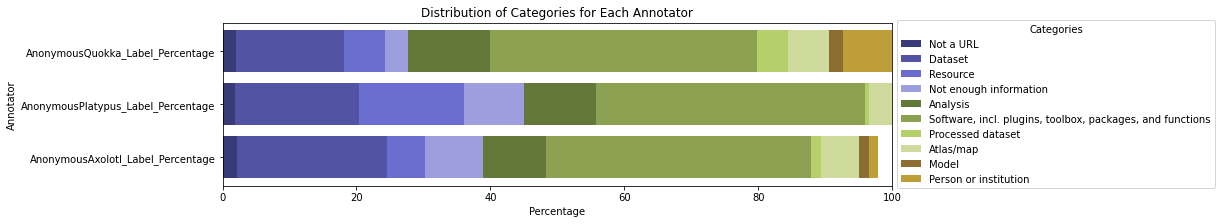

In [62]:
# Set up figure and axes
fig, ax = plt.subplots(figsize=(12, 3))

# Define colormap with enough distinct colors
cmap = plt.get_cmap('tab20b')

# Plot each annotator's data
for i, annotator in enumerate(annotators):
    values = [category_values[category][i] for category in category_values.keys() if category != 'Total_Labels']
    categories = [category for category in category_values.keys() if category != 'Total_Labels']

    # Calculate cumulative values for stacking
    cumulative_values = np.zeros(len(values))
    for j, value in enumerate(values):
        ax.barh(annotator, value, left=cumulative_values, color=cmap(j % len(cmap.colors)), label=categories[j] if i == 0 else "")
        cumulative_values += value

# Add legend to the right of the plot
ax.legend(title="Categories", loc="center left", bbox_to_anchor=(1, 0.5))

ax.set_title('Distribution of Categories for Each Annotator')
ax.set_xlabel('Percentage')
ax.set_ylabel('Annotator')

# Set x-axis limit to 100
ax.set_xlim(0, 100)

plt.show()

In [63]:
desired_order = [
    'Analysis',
    'Atlas/map',
    'Model',
    'Software, incl. plugins, toolbox, packages, and functions',
    'Person or institution',
    'Resource',
    'Dataset',
    'Processed dataset',
    'Not a URL',
    'Not enough information',
]

# Create a new dictionary with the desired order
reordered_dict = {key: category_values[key] for key in desired_order}

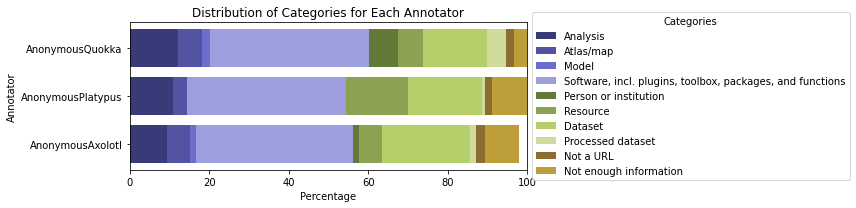

In [74]:
# Set up figure and axes
fig, ax = plt.subplots(figsize=(12, 3))

# Define colormap with enough distinct colors
cmap = plt.get_cmap('tab20b')

# Plot each annotator's data
for i, annotator in enumerate(annotators):
    values = [reordered_dict[category][i] for category in reordered_dict.keys() if category != 'Total_Labels']
    categories = [category for category in reordered_dict.keys() if category != 'Total_Labels']

    # Calculate cumulative values for stacking
    cumulative_values = np.zeros(len(values))
    for j, value in enumerate(values):
        ax.barh(annotator, value, left=cumulative_values, color=cmap(j % len(cmap.colors)), label=categories[j] if i == 0 else "")
        cumulative_values += value

# Add legend to the right of the plot
ax.legend(title="Categories", loc="center left", bbox_to_anchor=(1, 0.5))

ax.set_title('Distribution of Categories for Each Annotator')
ax.set_xlabel('Percentage')
ax.set_ylabel('Annotator')

# Set x-axis limit to 100
ax.set_xlim(0, 100)
plt.tight_layout()
plt.savefig('../../Results/graphics/QA_labelsDistribution_MyLabels.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

I want to investigate the distribution, using the labels by Zhao et al. 

In [65]:
# Convert all values in label_counts_df to integers
label_counts_df = label_counts_df[['AnonymousAxolotl_Label','AnonymousPlatypus_Label','AnonymousQuokka_Label']].astype(int)

# New categories mapping
new_categories = {
    "Analysis": 'Method',
    "Atlas/map": 'Method',
    "Dataset": 'Material',
    "Model": 'Method',
    "Person or institution": 'Supplement',
    "Processed dataset": 'Material',
    "Resource": 'Supplement',
    "Software, incl. plugins, toolbox, packages, and functions": 'Method',
}

# Create a new DataFrame with three rows based on the new categories
new_label_counts_df = pd.DataFrame(index=set(new_categories.values()), columns=label_counts_df.columns, dtype=int)

# Group and sum based on the new categories
for old_category, new_category in new_categories.items():
    new_label_counts_df.loc[new_category] = new_label_counts_df.loc[new_category].add(label_counts_df.loc[label_counts_df.index.str.contains(old_category)].sum(), fill_value=0)

# Add a new row for the total of each column
new_label_counts_df.loc['Total_Labels'] = new_label_counts_df.sum()

In [66]:
new_label_counts_df

,AnonymousAxolotl_Label,AnonymousPlatypus_Label,AnonymousQuokka_Label
Supplement,10.0,26.0,20.0
Material,33.0,32.0,31.0
Method,78.0,91.0,89.0
Total_Labels,121.0,149.0,140.0


In [67]:
# Create a new DataFrame for each annotator
annotators_dfs = {}

for annotator in label_counts_df.columns:
    # Create a new DataFrame with three rows based on the new categories
    new_label_counts_df = pd.DataFrame(index=set(new_categories.values()), columns=[annotator], dtype=int)

    # Group and sum based on the new categories
    for old_category, new_category in new_categories.items():
        new_label_counts_df.loc[new_category] = new_label_counts_df.loc[new_category].add(
            label_counts_df.loc[label_counts_df.index.str.contains(old_category), annotator].sum(), fill_value=0
        )

    # Add a new row for the total of each column
    new_label_counts_df.loc['Total_Labels'] = new_label_counts_df.sum()

    # Add percentage column
    total_labels = new_label_counts_df.loc['Total_Labels', annotator]
    new_label_counts_df['Percentage'] = round(new_label_counts_df[annotator] / total_labels * 100,1)

    annotators_dfs[annotator] = new_label_counts_df

In [68]:
annotators_dfs

{'AnonymousAxolotl_Label':               AnonymousAxolotl_Label  Percentage
 Supplement                      10.0         8.3
 Material                        33.0        27.3
 Method                          78.0        64.5
 Total_Labels                   121.0       100.0,
 'AnonymousPlatypus_Label':               AnonymousPlatypus_Label  Percentage
 Supplement                       26.0        17.4
 Material                         32.0        21.5
 Method                           91.0        61.1
 Total_Labels                    149.0       100.0,
 'AnonymousQuokka_Label':               AnonymousQuokka_Label  Percentage
 Supplement                     20.0        14.3
 Material                       31.0        22.1
 Method                         89.0        63.6
 Total_Labels                  140.0       100.0}

In [69]:
# Lists to store extracted values
annotators = []
method_values = []
supplement_values = []
material_values = []

# Iterate through annotators
for annotator, df in annotators_dfs.items():
    # Extract annotator name
    annotator_name = annotator.split('_')[0]
    
    # Append annotator name to the list
    annotators.append(annotator_name)
    
    # Extract values for method, supplement, and material
    method_value = df.loc['Method', 'Percentage']
    supplement_value = df.loc['Supplement', 'Percentage']
    material_value = df.loc['Material', 'Percentage']
    
    # Append values to respective lists
    method_values.append(method_value)
    supplement_values.append(supplement_value)
    material_values.append(material_value)

# Print the lists
print("Annotators:", annotators)
print("Method Values:", method_values)
print("Supplement Values:", supplement_values)
print("Material Values:", material_values)

Annotators: ['AnonymousAxolotl', 'AnonymousPlatypus', 'AnonymousQuokka']
Method Values: [64.5, 61.1, 63.6]
Supplement Values: [8.3, 17.4, 14.3]
Material Values: [27.3, 21.5, 22.1]


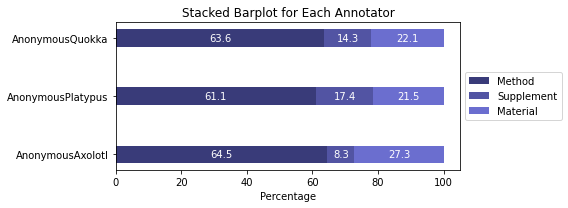

In [73]:
# Set up positions for the bars
bar_width = 0.3
bar_positions = np.arange(len(annotators))

# Get the first three colors from the tab20b colormap
colors = plt.cm.tab20b(np.arange(3))

# Set a slimmer figure size
fig, ax = plt.subplots(figsize=(8, 3))  # Adjust the width (8) and height (3) as needed

# Plot the bars with correct colormap
method_bars = plt.barh(bar_positions, method_values, color=colors[0], label='Method', height=bar_width) #edgecolor='black'
supplement_bars = plt.barh(bar_positions, supplement_values, left=method_values, color=colors[1], label='Supplement', height=bar_width)
material_bars = plt.barh(bar_positions, material_values, left=np.add(method_values, supplement_values), color=colors[2], label='Material', height=bar_width)

# Set labels and title
plt.yticks(bar_positions, annotators)
plt.xlabel('Percentage')
plt.title('Stacked Barplot for Each Annotator')

# Add values to the bars
for bars, values in zip([method_bars, supplement_bars, material_bars], [method_values, supplement_values, material_values]):
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f"{value:.1f}", color='white', ha='center', va='center')

# Move legend outside of the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('../../Results/graphics/QA_labelsDistribution_Zhao.png',bbox_inches='tight', pad_inches=0.1)
plt.show()

<a name='labelsoccurringtogether'></a>
### Labels occurring together 

I will use a heatmap to visualize the frequency that certain labels appearing together. 

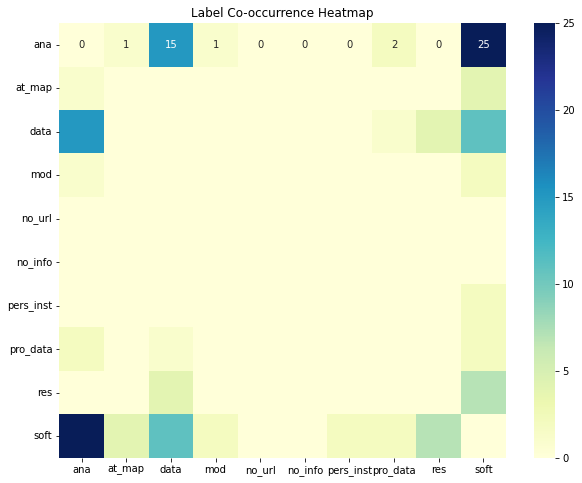

In [71]:
# Create an empty co-occurrence matrix
labels = list(label_mapping.values())
co_occurrence_matrix = pd.DataFrame(0, columns=labels, index=labels, dtype=int)

# Iterate through rows in sentences_df
for labels_list in sentences_df['Labels']:
    unique_labels = set(labels_list)
    for label1 in unique_labels:
        for label2 in unique_labels:
            if label1 != label2:
                co_occurrence_matrix.at[label1, label2] += 1

# Plot a heatmap of the co-occurrence matrix
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Label Co-occurrence Heatmap')

plt.savefig('../../Results/graphics/QA_labels_coOccurrence.png')
plt.show()

Focusing on the labels that were most frequently used with the label 'Dataset':

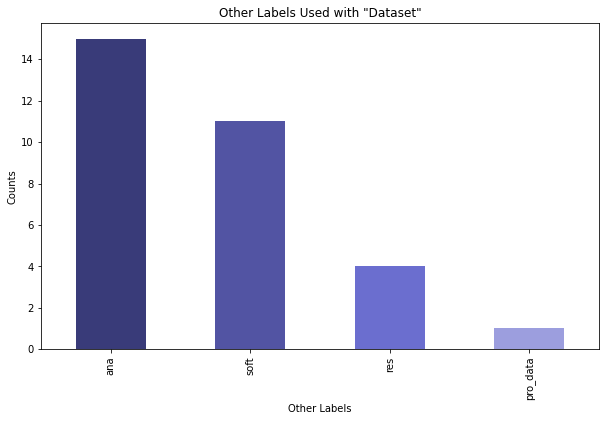

In [72]:
dataset_occurrences = sentences_df[sentences_df['Labels'].apply(lambda x: 'data' in x)]

# Extract and count other labels used with 'Dataset'
other_labels_with_dataset = dataset_occurrences['Labels'].apply(lambda x: [label for label in x if label != 'data'])
other_labels_counts = pd.Series([label for labels in other_labels_with_dataset for label in labels]).value_counts()

colors = plt.cm.tab20b(range(len(other_labels_counts)))

# Plot the other labels used with 'Dataset' using the tab20b colormap
plt.figure(figsize=(10, 6))
other_labels_counts.plot(kind='bar', color=colors)
plt.xlabel('Other Labels')
plt.ylabel('Counts')
plt.title('Other Labels Used with "Dataset"')
plt.savefig('../../Results/graphics/QA_labels_datasetLabelCooccurrences.png')
plt.show()

<a name='references'></a>
# References 
- Artstein, R., & Poesio, M. (2008). Inter-Coder Agreement for Computational Linguistics. Computational Linguistics, 34(4), 555–596. https://doi.org/10.1162/coli.07-034-R2
- Bird, S., Loper, E., & Klein, E. (2009). Natural Language Processing with Python. O’Reilly Media, INC.
- Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering, 9(3), 90–95. https://doi.org/10.1109/MCSE.2007.55
- Krippendorff, K. (2004). Reliability in Content Analysis: Some Common Misconceptions and Recommendations. Human Communication Research, 30(3), 411–433. https://doi.org/10.1093/hcr/30.3.411
- NLTK. (2023). Nltk.metrics.agreement module (3.8.1) [Python]. https://www.nltk.org/api/nltk.metrics.agreement.html
- Rampin, R., & Rampin, V. (2021). Taguette: Open-source qualitative data analysis. Journal of Open Source Software, 6(68), 3522. https://doi.org/10.21105/joss.03522
- Waskom, M. L. (2021). seaborn: Statistical data visualization. Journal of Open Source Software, 6(60), 3021. https://doi.org/10.21105/joss.03021